In [ ]:
import os
import zipfile
import requests

# Download the dataset
url = 'https://github.com/snapmoo/ML-Dataset/raw/main/Augmented_FMD_Cattle_Dataset1.zip'
zip_file_path = 'Augmented_FMD_Cattle_Dataset1.zip'

response = requests.get(url)
with open(zip_file_path, 'wb') as file:
    file.write(response.content)

# Extract the dataset
extract_to_path = 'dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to train, validation, and test directories
train_dir = os.path.join(extract_to_path, 'train')
validation_dir = os.path.join(extract_to_path, 'validation')
test_dir = os.path.join(extract_to_path, 'test')

# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Create ImageDataGenerator for test without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1144 images belonging to 2 classes.
Found 249 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [ ]:
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Memuat model dasar VGG16 tanpa lapisan atas (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan lapisan-lapisan dari model dasar
for layer in base_model.layers:
    layer.trainable = False

# Membuat model baru dengan menambahkan lapisan-lapisan di atas model dasar
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Callbacks untuk early stopping dan model checkpoint



# Pelatihan model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/100
35/35 [==============================] - 18s 467ms/step - loss: 1.6278 - accuracy: 0.6277 - val_loss: 0.5745 - val_accuracy: 0.7009
Epoch 2/100
35/35 [==============================] - 15s 430ms/step - loss: 0.4539 - accuracy: 0.7815 - val_loss: 0.3752 - val_accuracy: 0.8304
Epoch 3/100
35/35 [==============================] - 15s 440ms/step - loss: 0.4208 - accuracy: 0.8040 - val_loss: 0.3667 - val_accuracy: 0.8348
Epoch 4/100
35/35 [==============================] - 16s 456ms/step - loss: 0.3897 - accuracy: 0.8255 - val_loss: 0.3341 - val_accuracy: 0.8571
Epoch 5/100
35/35 [==============================] - 15s 440ms/step - loss: 0.3650 - accuracy: 0.8399 - val_loss: 0.3757 - val_accuracy: 0.8438
Epoch 6/100
35/35 [==============================] - 15s 437ms/step - loss: 0.3877 - accuracy: 0.8345 - val_loss: 0.2969 - val_accuracy: 0.8750
Epoch 7/100
35/35 [==============================] - 15s 439ms/step - loss: 0.3571 - accuracy: 0.8318 - val_loss: 0.2617 - val_accuracy:

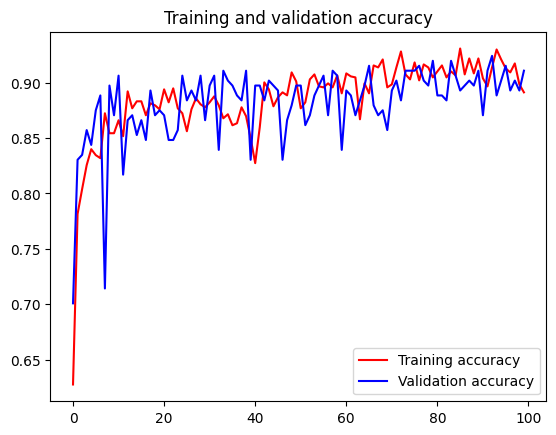

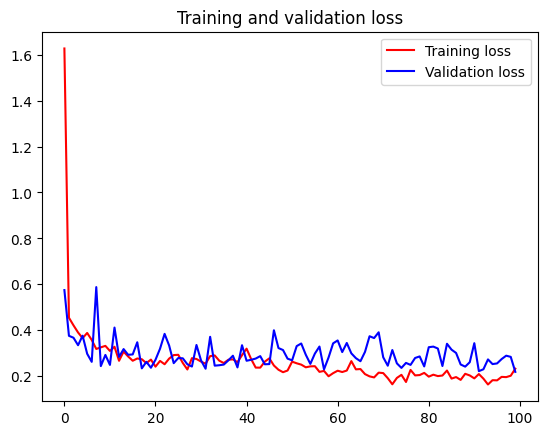

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from PIL import Image
import io
import numpy as np

def on_upload_change(change):
    clear_output(wait=True)

    # Proses file yang diunggah
    if change['new']:
        for name, file_info in change['new'].items():
            file_content = file_info['content']
            img = Image.open(io.BytesIO(file_content))

            # Tampilkan gambar yang diunggah
            display(HTML("<h3>Uploaded Image:</h3>"))
            display(widgets.Image(value=file_content, format='jpg'))

            # Prediksi gambar
            pmk_label, pmk_confidence= process_and_predict(img)

            if pmk_label is None:
                display(HTML('<p style="color:red;">Error processing the image.</p>'))
            else:
                display(HTML(f"<h3>Prediction Result:</h3>"))
                display(HTML(f"<p>PMK Prediction: <strong>{pmk_label}</strong> ({pmk_confidence * 100:.2f}% confidence)</p>"))

In [ ]:
def process_and_predict(image):
    try:
        # Resize dan preprocess gambar
        img = image.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)

        # Debug print untuk memeriksa prediksi mentah
        print("Predictions:", predictions)

        # Prediksi PMK
        pmk_pred = predictions[0][0]
        pmk_label = 'Terkena PMK' if pmk_pred > 0.5 else 'Tidak terkena PMK'
        pmk_confidence = pmk_pred if pmk_pred > 0.5 else 1 - pmk_pred

        return pmk_label, float(pmk_confidence)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [ ]:
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')

display(HTML("<h2>Upload Image to Predict PMK and Body Part</h2>"))
display(upload_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\xe8\x86Exif\x00\x00II*\x0…

1/1 [==============================] - 0s 19ms/step
Predictions: [[0.95996696]]


In [ ]:
import os
from keras.preprocessing.image import load_img, img_to_array

def process_and_predict(image_path):
    try:
        # Load dan resize gambar
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)

        # Prediksi PMK
        pmk_pred = predictions[0][0]
        pmk_label = 'Terkena PMK' if pmk_pred > 0.5 else 'Tidak terkena PMK'
        pmk_confidence = pmk_pred if pmk_pred > 0.5 else 1 - pmk_pred

        return pmk_label, float(pmk_confidence)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Predict all images in the test folder
test_folder = os.path.dirname(test_generator.filepaths[0])  # Assuming all images are in the same directory
image_files = test_generator.filepaths

for image_file in image_files:
    label, confidence = process_and_predict(image_file)
    print(f"File: {image_file} - Predicted: {label} with confidence: {confidence}")

1/1 [==============================] - 0s 17ms/step
File: dataset/test/0/img138.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9998192489147186
1/1 [==============================] - 0s 18ms/step
File: dataset/test/0/img139.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9993167613865808
1/1 [==============================] - 0s 20ms/step
File: dataset/test/0/img140.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9999998464087128
1/1 [==============================] - 0s 19ms/step
File: dataset/test/0/img141.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9820864573121071
1/1 [==============================] - 0s 20ms/step
File: dataset/test/0/img142.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9999089041230036
1/1 [==============================] - 0s 19ms/step
File: dataset/test/0/img143.jpeg - Predicted: Tidak terkena PMK with confidence: 0.9900772124528885
1/1 [==============================] - 0s 19ms/step
File: dataset/test/0/img144.jpeg - P

In [ ]:

import tensorflow as tf

# Menyimpan model keras yang telah dilatih
model.save('trained_model.h5')

# Mengonversi model keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = 'trained_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model TFLite saved successfully.")


import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Fungsi untuk memuat model TFLite
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

# Fungsi untuk menjalankan inferensi pada model TFLite
def run_inference(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Mengonfigurasi ImageDataGenerator untuk set data uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Memuat model TFLite
tflite_model_path = 'trained_model.tflite'
interpreter = load_tflite_model(tflite_model_path)

# Evaluasi model TFLite
correct_predictions = 0
total_samples = len(test_generator.filenames)

for i in range(total_samples):
    x, y_true = test_generator[i]
    y_true = y_true[0]

    # Preprocessing image for TFLite model
    y_pred = run_inference(interpreter, x)
    y_pred_label = np.argmax(y_pred)

    # Assuming binary classification with labels 0 and 1
    if y_pred_label == y_true:
        correct_predictions += 1

accuracy = correct_predictions / total_samples
print(f'Model TFLite accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model TFLite saved successfully.
Found 51 images belonging to 2 classes.
Model TFLite accuracy: 49.02%


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Simpan model ke file .h5
model.save("my_model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

# Plot the model architecture and save as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Memeriksa apakah file telah disimpan
if os.path.exists("my_model.h5"):
    print("Model .h5 telah disimpan.")

if os.path.exists("my_model.tflite"):
    print("Model TFLite telah disimpan.")

if os.path.exists("model_architecture.png"):
    print("Diagram arsitektur model telah disimpan.")

# Menyimpan model dan file TFLite ke dalam folder yang bisa di-download
from google.colab import files

files.download("my_model.h5")
files.download("my_model.tflite")
files.download("model_architecture.png")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model .h5 telah disimpan.
Model TFLite telah disimpan.
Diagram arsitektur model telah disimpan.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Simpan model ke dalam format JSON
model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# Memeriksa apakah file telah disimpan
if os.path.exists("my_model.json"):
    print("Model JSON telah disimpan.")

# Menyimpan model JSON ke dalam folder yang bisa di-download
from google.colab import files

files.download("my_model.json")

Model JSON telah disimpan.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>